# Chapter III: Separable PINNs

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])
import pickle
import copy

results_folder = '../results/III_ImprovingPINNs'
from phd.models import allen_cahn
from phd.config import PlottingConfig, get_current_config, book_config, book_compact_config, A4_config

# --- Figure settings ---
save_fig = True

# Initialize plotting configuration
book_config.set_as_current()

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [7]:
import deepxde as dde
import jax
import jax.numpy as jnp

layers = [2] + [32] * 2 + [16] + [2]
spinn_net = dde.nn.SPINN(layers, "tanh", "Glorot uniform")
params = spinn_net.init(jax.random.PRNGKey(0), jnp.ones((1,2)))
spinn_net.params = params

layers = [2] + [[32] * 2] * 3 + [2]
pfnn_net = dde.nn.PFNN(layers, "tanh", "Glorot uniform")
params = pfnn_net.init(jax.random.PRNGKey(0), jnp.ones((1,2)))
pfnn_net.params = params

def number_of_parameters(net):
                return sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, net.params)))
print(f"SPINN Parameters: {number_of_parameters(spinn_net):,}")
print(f"PFNN Parameters: {number_of_parameters(pfnn_net):,}")

SPINN Parameters: 4,352
PFNN Parameters: 4,482


In [3]:
def estimate_flops(net, net_name, n_batch=100):
    if net_name == "PFNN":
        X_test = jnp.ones((n_batch**2, 2))
    else:
        X_test = [jnp.ones((n_batch, 1)), jnp.ones((n_batch, 1))]
    model_func = lambda x: net.apply(net.params, x)
    compiled = jax.jit(model_func).lower(X_test).compile()
    flops = compiled.cost_analysis()['flops']
    return flops

def number_of_parameters(net):
                return sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, net.params)))

# Print summary table of model complexities
nets = {'PFNN': pfnn_net, 'SPINN': spinn_net}

for name, net in nets.items():
    params = number_of_parameters(net)
    flops = estimate_flops(net, name)  # Fixed: was `model_name`, should be `name`
    print(f"{name}: Parameters: {params:,}, FLOPs: {flops:,.0f}")

PFNN: Parameters: 4,482, FLOPs: 85,740,000
SPINN: Parameters: 6,464, FLOPs: 2,515,200


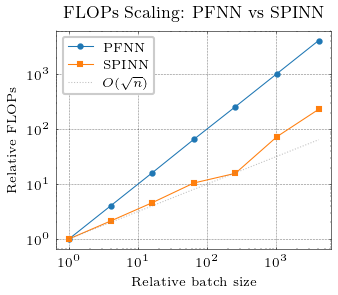

At 256² points: PFNN=561,905,664 FLOPs, SPINN=11,550,720 FLOPs
Speedup: 48.6x fewer FLOPs for SPINN


In [5]:
# FLOPs scaling analysis: PFNN (linear) vs SPINN (sqrt)
batch_sizes = [4, 8, 16, 32, 64, 128, 256]

pfnn_flops = []
spinn_flops = []

for n in batch_sizes:
    # PFNN: n^2 total points (grid), each goes through the full network
    pfnn_flops.append(estimate_flops(pfnn_net, "PFNN", n_batch=n))
    # SPINN: n points per dimension, processes each dim separately
    spinn_flops.append(estimate_flops(spinn_net, "SPINN", n_batch=n))

# Total points for each batch size
total_points = [n**2 for n in batch_sizes]

# Plot: FLOPs scaling behavior (normalized)
page_width = get_current_config().page_width
fig, ax = plt.subplots(figsize=(page_width/2, page_width/2.5), dpi=150)

pfnn_normalized = np.array(pfnn_flops) / pfnn_flops[0]
spinn_normalized = np.array(spinn_flops) / spinn_flops[0]
points_normalized = np.array(total_points) / total_points[0]

ax.plot(points_normalized, pfnn_normalized, 'o-', label='PFNN', color='tab:blue')
ax.plot(points_normalized, spinn_normalized, 's-', label='SPINN', color='tab:orange')
# ax.plot(points_normalized, points_normalized, '--', label=r'$O(n)$', color='gray', alpha=0.5)
ax.plot(points_normalized, np.sqrt(points_normalized), ':', label=r'$O(\sqrt{n})$', color='gray', alpha=0.5)
ax.set_xlabel('Relative batch size')
ax.set_ylabel('Relative FLOPs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('FLOPs Scaling: PFNN vs SPINN')

plt.show()

# Print speedup at largest batch
print(f"At {batch_sizes[-1]}² points: PFNN={pfnn_flops[-1]:,.0f} FLOPs, SPINN={spinn_flops[-1]:,.0f} FLOPs")
print(f"Speedup: {pfnn_flops[-1]/spinn_flops[-1]:.1f}x fewer FLOPs for SPINN")

In [6]:
# Compare autodiff FLOPs: forward-mode (jvp) vs reverse-mode (grad) for SPINN vs PFNN
# Computing FULL Jacobian: ∂f/∂x for all outputs at all points
# Forward-mode (jvp): O(n_inputs) passes - efficient when n_inputs << n_outputs
# Reverse-mode (grad): O(n_outputs) passes - efficient when n_outputs << n_inputs

# Network dimensions
n_hidden = 3
n_outputs = 2  # Network has 2 outputs


layers = [2] + [32] * (n_hidden-1) + [32] + [n_outputs]
spinn_net = dde.nn.SPINN(layers, "tanh", "Glorot uniform")
params = spinn_net.init(jax.random.PRNGKey(0), jnp.ones((1,2)))
spinn_net.params = params

layers = [2] + [[32] * 2] * n_hidden + [n_outputs]
pfnn_net = dde.nn.PFNN(layers, "tanh", "Glorot uniform")
params = pfnn_net.init(jax.random.PRNGKey(0), jnp.ones((1,2)))
pfnn_net.params = params

n = 256  # points per dimension
# Define test inputs
X_pfnn = jnp.ones((n**2, 2))
X_spinn = [jnp.ones((n, 1)), jnp.ones((n, 1))]

# --- PFNN derivatives: reverse-mode ---
def pfnn_grad_full(net, x):
    """Compute full Jacobian df/dx at each point using reverse-mode.
    Returns shape (n_points, n_outputs, n_inputs)"""
    def jacobian_at_point(xi):
        # jax.jacrev: reverse-mode Jacobian, shape (n_outputs, n_inputs)
        return jax.jacrev(lambda x_in: net.apply(net.params, x_in[None, :])[0])(xi)
    return jax.vmap(jacobian_at_point)(x)

# --- PFNN derivatives: forward-mode ---
def pfnn_jvp_full(net, x):
    """Compute full Jacobian df/dx at each point using forward-mode.
    Returns shape (n_points, n_outputs, n_inputs)"""
    def jacobian_at_point(xi):
        # jax.jacfwd: forward-mode Jacobian, shape (n_outputs, n_inputs)
        return jax.jacfwd(lambda x_in: net.apply(net.params, x_in[None, :])[0])(xi)
    return jax.vmap(jacobian_at_point)(x)

# --- SPINN derivatives: forward-mode (jvp) - efficient for SPINN ---
def spinn_jvp_full(net, x):
    """Compute df/dx1 for all outputs using forward-mode (single pass per input dim).
    Returns shape (n, n_outputs) for derivative w.r.t. x1"""
    x1, x2 = x[0], x[1]
    # Forward-mode: one pass gives derivatives of ALL outputs w.r.t. x1
    tangent = jnp.ones_like(x1)
    _, df_dx1 = jax.jvp(
        lambda x1_in: net.apply(net.params, [x1_in, x2]),
        (x1,),
        (tangent,)
    )
    return df_dx1  # shape: (n, n_outputs)

# --- SPINN derivatives: reverse-mode (grad) - less efficient for SPINN ---
def spinn_grad_full(net, x):
    """Compute df/dx1 for all outputs using reverse-mode.
    Need n_outputs backward passes. Returns shape (n, n_outputs)"""
    x1, x2 = x[0], x[1]
    n_pts = x1.shape[0]
    
    def get_jacobian_col(out_idx):
        # For each output, compute gradient w.r.t. x1
        def scalar_fn(x1_in):
            return net.apply(net.params, [x1_in, x2])[:, out_idx].sum()
        return jax.grad(scalar_fn)(x1)
    
    # Stack gradients for all outputs: (n_outputs, n) -> transpose to (n, n_outputs)
    return jax.vmap(get_jacobian_col)(jnp.arange(n_outputs)).T

# Compile and measure FLOPs
print(f"Comparing autodiff for computing FULL Jacobian ∂f/∂x")
print(f"Network: 2 inputs → {n_outputs} outputs")
print(f"PFNN: {n}² = {n**2:,} points, SPINN: {n} × {n} separable grid\n")

# PFNN reverse-mode (jacrev)
pfnn_grad_compiled = jax.jit(lambda x: pfnn_grad_full(pfnn_net, x)).lower(X_pfnn).compile()
pfnn_grad_flops = pfnn_grad_compiled.cost_analysis()['flops']

# PFNN forward-mode (jacfwd)
pfnn_jvp_compiled = jax.jit(lambda x: pfnn_jvp_full(pfnn_net, x)).lower(X_pfnn).compile()
pfnn_jvp_flops = pfnn_jvp_compiled.cost_analysis()['flops']

# SPINN forward-mode (jvp) - single pass for all outputs!
spinn_jvp_compiled = jax.jit(lambda x: spinn_jvp_full(spinn_net, x)).lower(X_spinn).compile()
spinn_jvp_flops = spinn_jvp_compiled.cost_analysis()['flops']

# SPINN reverse-mode (grad) - needs n_outputs passes
spinn_grad_compiled = jax.jit(lambda x: spinn_grad_full(spinn_net, x)).lower(X_spinn).compile()
spinn_grad_flops = spinn_grad_compiled.cost_analysis()['flops']

# Print results
print(f"{'Method':<30} {'FLOPs':>15} {'Relative':>10}")
print("-" * 58)
print(f"{'PFNN (jacrev/reverse)':<30} {pfnn_grad_flops:>15,.0f} {pfnn_grad_flops/pfnn_grad_flops:>10.1f}x")
print(f"{'PFNN (jacfwd/forward)':<30} {pfnn_jvp_flops:>15,.0f} {pfnn_grad_flops/pfnn_jvp_flops:>10.1f}x")
print(f"{'SPINN (reverse-mode)':<30} {spinn_grad_flops:>15,.0f} {pfnn_grad_flops/spinn_grad_flops:>10.1f}x")
print(f"{'SPINN (forward-mode/jvp)':<30} {spinn_jvp_flops:>15,.0f} {pfnn_grad_flops/spinn_jvp_flops:>10.1f}x")
print("-" * 58)
print(f"\nKey insights (full Jacobian: 2 inputs → {n_outputs} outputs):")
print(f"  PFNN: jacfwd ~{pfnn_grad_flops/pfnn_jvp_flops:.1f}x faster than jacrev (2 inputs < {n_outputs} outputs)")
print(f"  SPINN jvp vs SPINN grad: {spinn_grad_flops/spinn_jvp_flops:.1f}x speedup")
print(f"  SPINN jvp vs PFNN jacfwd: {pfnn_jvp_flops/spinn_jvp_flops:.1f}x speedup (separable structure)")

Comparing autodiff for computing FULL Jacobian ∂f/∂x
Network: 2 inputs → 2 outputs
PFNN: 256² = 65,536 points, SPINN: 256 × 256 separable grid

Method                                   FLOPs   Relative
----------------------------------------------------------
PFNN (jacrev/reverse)            1,749,287,040        1.0x
PFNN (jacfwd/forward)            1,731,985,920        1.0x
SPINN (reverse-mode)                22,371,840       78.2x
SPINN (forward-mode/jvp)            12,140,544      144.1x
----------------------------------------------------------

Key insights (full Jacobian: 2 inputs → 2 outputs):
  PFNN: jacfwd ~1.0x faster than jacrev (2 inputs < 2 outputs)
  SPINN jvp vs SPINN grad: 1.8x speedup
  SPINN jvp vs PFNN jacfwd: 142.7x speedup (separable structure)
